# Constraint Learning 

### Librairies

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 


### Importing the NSL_KDD dataset


In [2]:
data_train = pd.read_csv('../datasets/NSL-KDD/KDDTrain+.txt')
data_test = pd.read_csv('../datasets/NSL-KDD/KDDTest+.txt')


columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells',
'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

data_train.columns = columns
data_test.columns = columns

### Exploring the data

#### 1. explore

In [3]:
print(data_train.shape)
print(data_test.shape)


(125972, 43)
(22543, 43)


In [4]:
data_train.info()
#: no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [5]:
data_train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [6]:
## The 'level' and 'outcome' features are the two output of features
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


#### 2. turn output classes to boolean feature

In [7]:
## change outputs from natural to boolean
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

data_test.loc[data_test['outcome'] == "normal", "outcome"] = 'normal'
data_test.loc[data_test['outcome'] != 'normal', "outcome"] = 'attack'


In [8]:
data_train['outcome'].head()
data_train['outcome'].describe()


count     125972
unique         2
top       normal
freq       67342
Name: outcome, dtype: object

#### 3. plot

In [9]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()


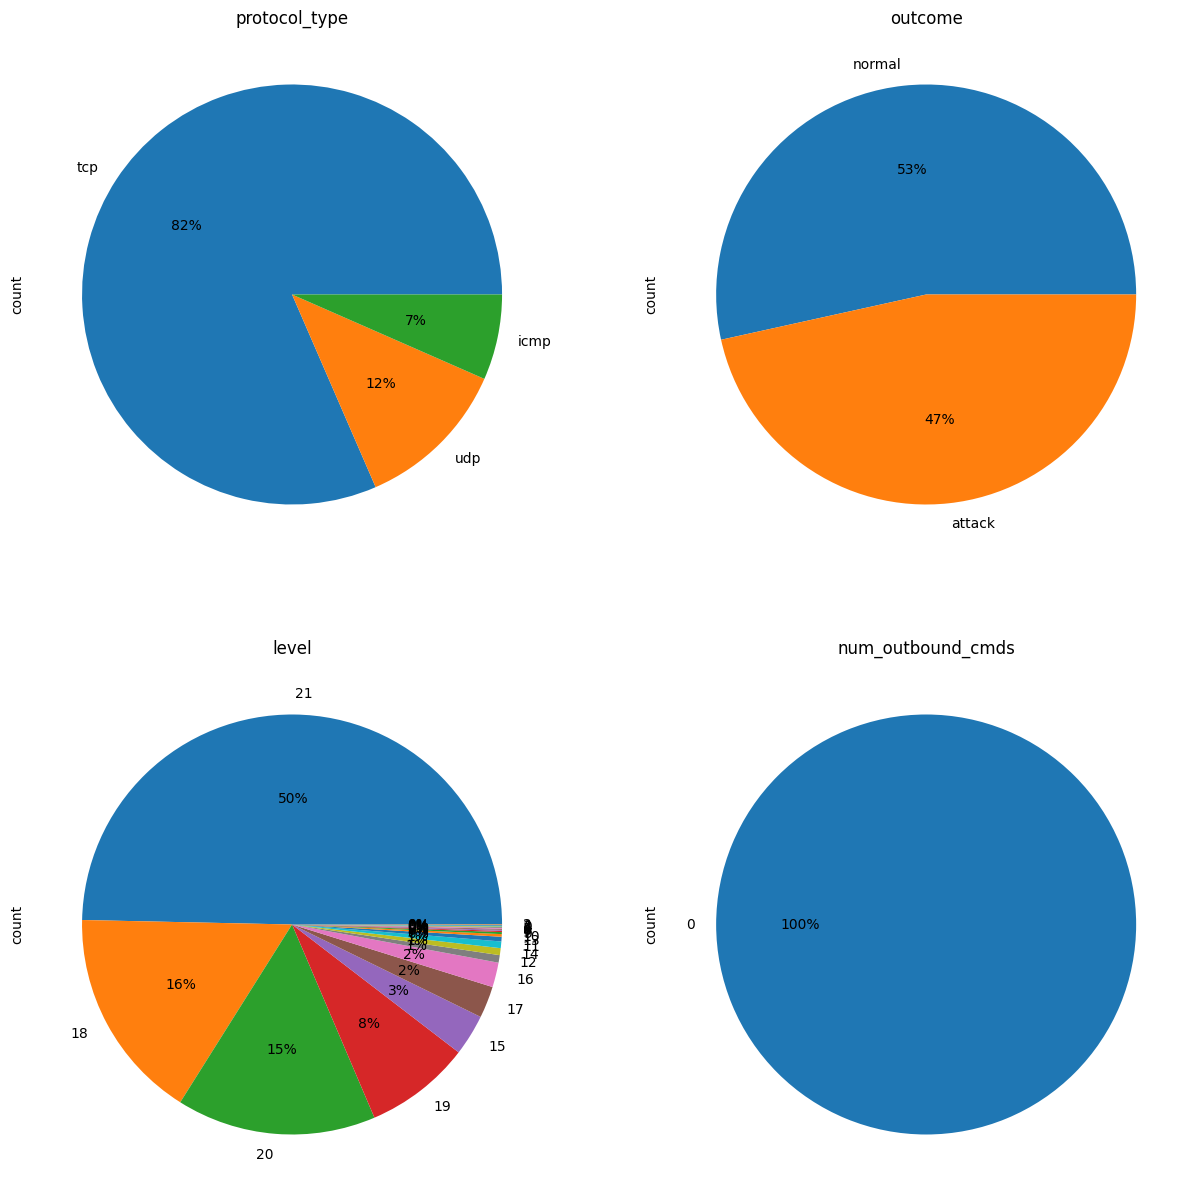

In [10]:
pie_plot(data_train, ['protocol_type', 'outcome', 'level', 'num_outbound_cmds'], 2, 2)
# service

#### 4. classes_per_feature ++ Pearson's R

In [11]:
'''    
  @-> amount of label(category) of each features   
'''
def label_count(df):
  label_counts = df.nunique()
  return pd.DataFrame({
      'label_count': label_counts
  })

features = label_count(data_train)
# features.head()


In [12]:
from scipy.stats import pearsonr

'''    
  @-> correlation coefficient   
'''

def pearson_r(df, target_feature):
  pearson = pd.Series(name='pearson_r')

  categories = {'num': [],'str': []}
  targeted = pd.Series(pd.factorize(df[target_feature])[0]).astype(float)
  for column in df.columns:
    corr = 0
    # if column != target_feature:
    if df[column].dtype not in ['int64', 'float64']:
      categories['str'].append(column)
      factorized = pd.Series(pd.factorize(df[column])[0]).astype(float)
      # corr = factorized.corr(targeted, method='pearson', min_periods=1)
      corr, pvalue = pearsonr(factorized, targeted)
    else:
      categories['num'].append(column)
      df[column].astype(float)
      # corr = df[column].corr(targeted, method='pearson', min_periods=1)
      corr, pvalue = pearsonr(df[column], targeted)
      
    pearson[column] = corr

  return categories, pearson

print(pd.__version__)
types, pearson = pearson_r(data_train, 'outcome')
# pearson.sort_values(ascending=False)


2.0.1


In [13]:
features['pearson_r'] = pearson
# features[features['pearson_r'] < 0].sort_values("pearson_r", ascending=True)
# features.sort_values("pearson_r", ascending=False)


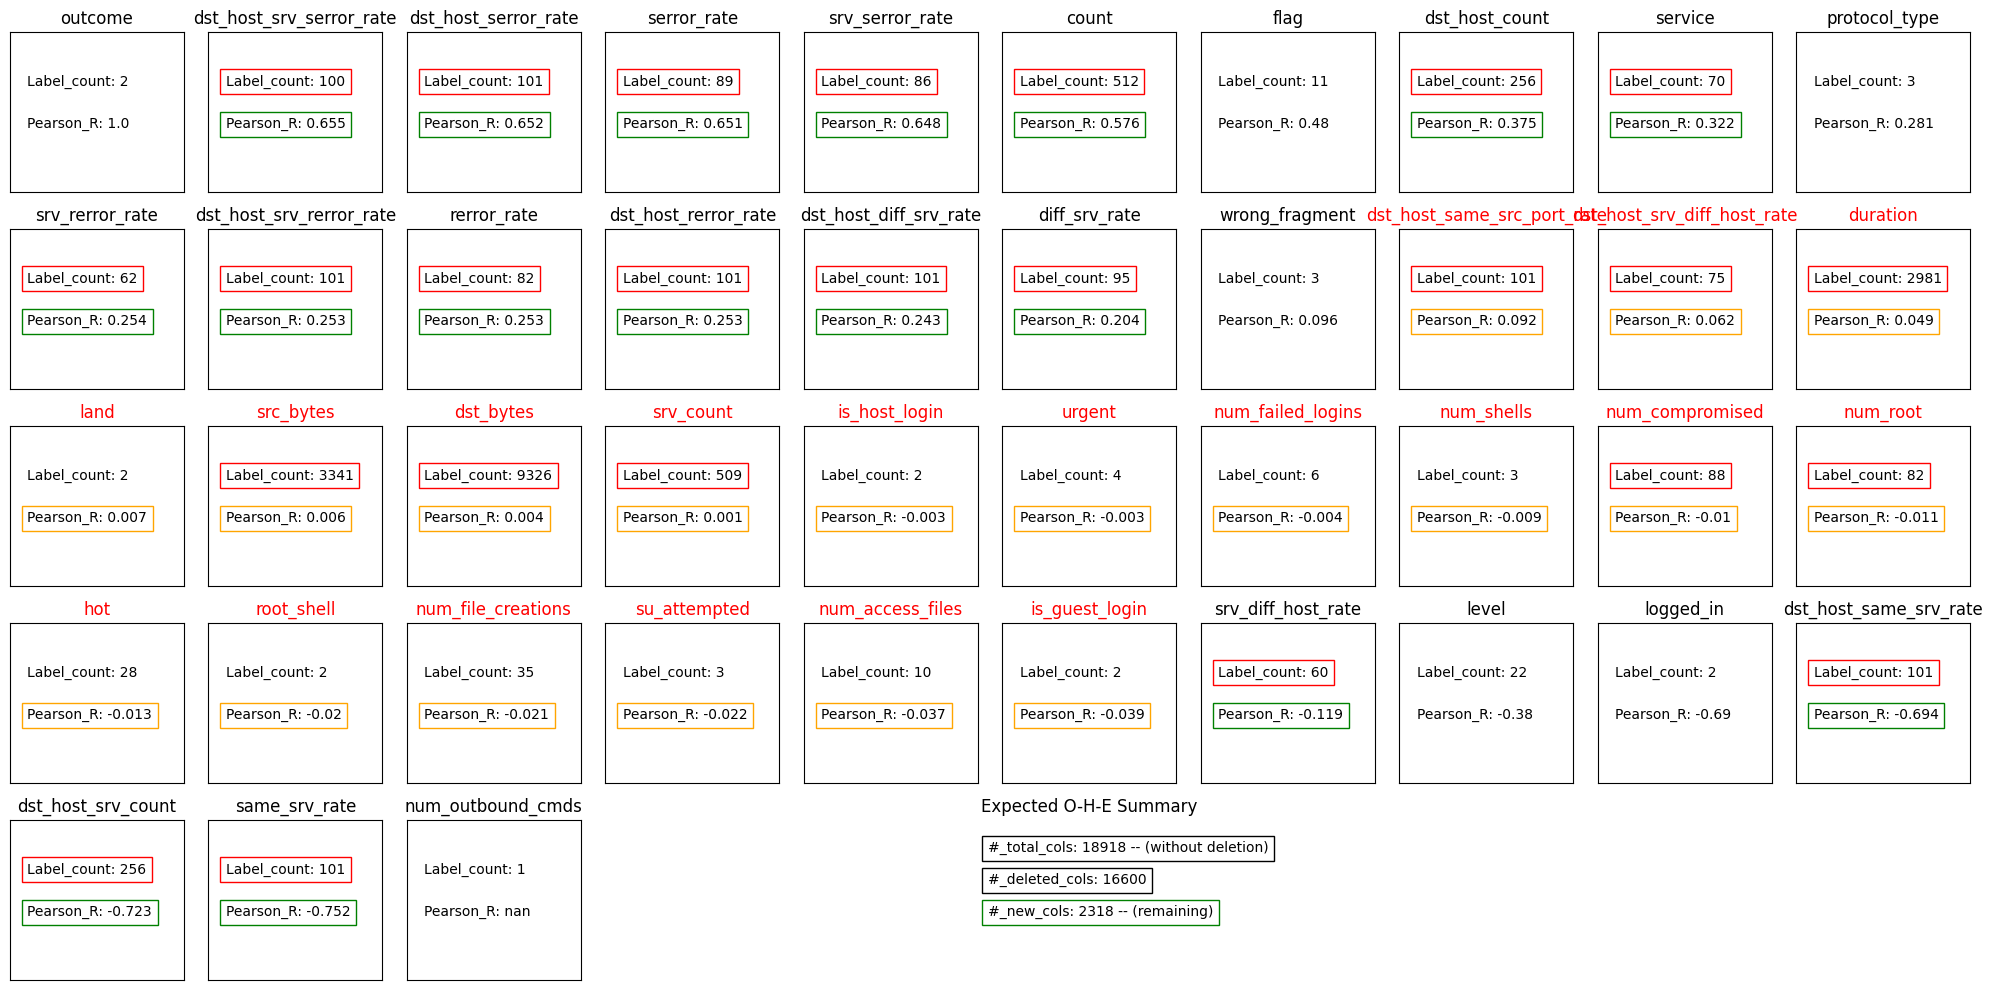

In [14]:
# specify the number of rows and columns you want to see
num_row = 5
num_col = 10

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))

# off last cells
for i in range(3, 10):
  axes[-1, i].axis('off')

# draw
for i, col in enumerate(features.sort_values("pearson_r", ascending=False).index):
    x, y = i//num_col, i % num_col
    ax = axes[x, y]
    column_to_delele = ['dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','duration','land','src_bytes','dst_bytes','srv_count','is_host_login','urgent','num_failed_logins','num_shells','num_compromised','num_root','hot','root_shell','num_file_creations','su_attempted','num_access_files','is_guest_login',]
    treshold, label_count_bbox, pearson_r_bbox, col_color = 50, None, None, 'black'

    if col in column_to_delele:
      pearson_r_bbox = dict(fill=False, edgecolor='orange', linewidth=1)
      col_color = 'red'

    if col in column_to_delele and features.loc[col, 'label_count'] > treshold:
      label_count_bbox = dict(fill=False, edgecolor='red', linewidth=1)

    if col not in column_to_delele and features.loc[col, 'label_count'] > treshold:
      label_count_bbox = dict(fill=False, edgecolor='red', linewidth=1)
      pearson_r_bbox = dict(fill=False, edgecolor='green', linewidth=1)
       
    ax.text(.1, .667, f"Label_count: {features.loc[col, 'label_count']}", bbox=label_count_bbox)
    ax.text(.1, .4, f"Pearson_R: {round(features.loc[col, 'pearson_r'], 3)}", bbox=pearson_r_bbox)
    ax.set_title(col, color=col_color)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Shape the layout 
plt.tight_layout()

# Last: summary
axes[-1, 5].set_title('Expected O-H-E Summary')
axes[-1, 3].text(2.2, .8, f"#_total_cols: {features['label_count'].sum()} -- (without deletion)", bbox=dict(fill=False, edgecolor='black', linewidth=1))
axes[-1, 3].text(2.2, .6, f"#_deleted_cols: {features[features.index.isin(column_to_delele)]['label_count'].sum()}", bbox=dict(fill=False, edgecolor='black', linewidth=1))
axes[-1, 3].text(2.2, .4, f"#_new_cols: {features[~features.index.isin(column_to_delele)]['label_count'].sum()} -- (remaining)", bbox=dict(fill=False, edgecolor='green', linewidth=1))

plt.show()


#### 5. correlation coefficient

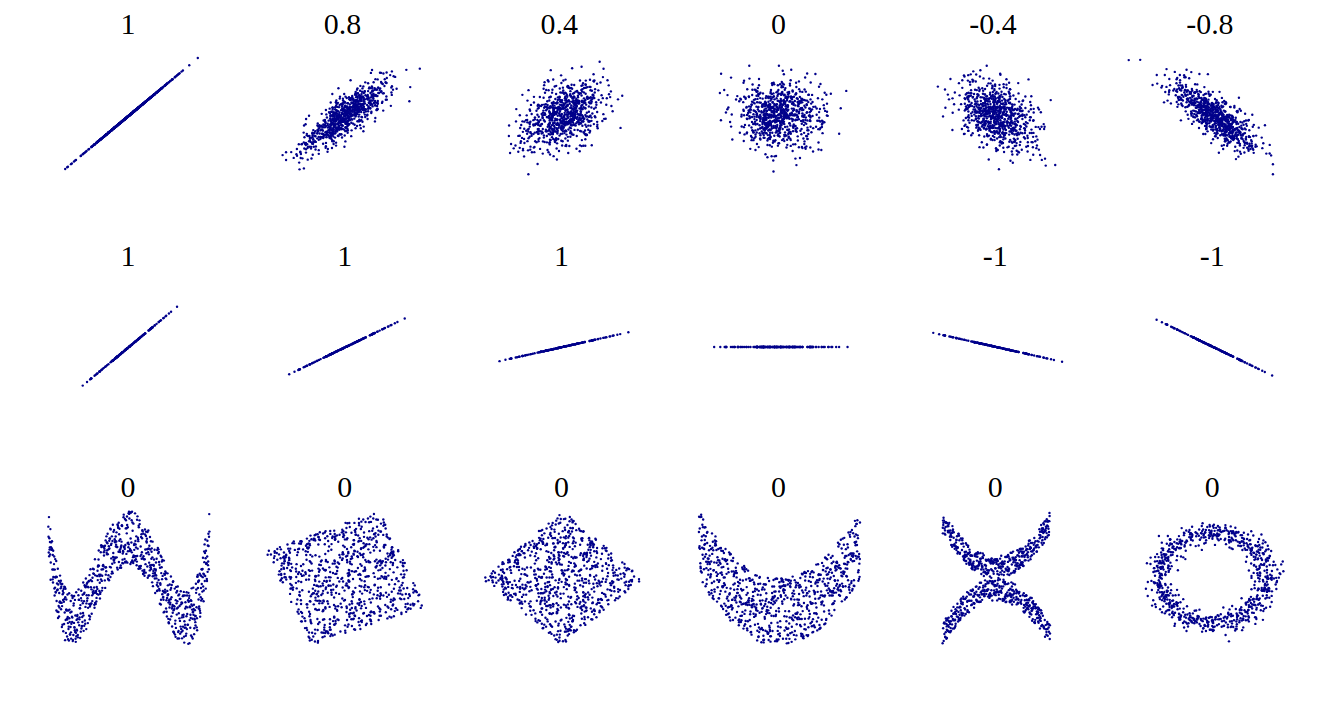

In [15]:
from IPython.display import Image

correlation_coeffcicient = 'images/corr.png'
Image(filename=correlation_coeffcicient)


In [16]:
#################
'''    TEST   '''
#################

df = pd.DataFrame({
    "feature_0": [-1, -1, 0, 0, -1],
    "feature_1": [1, 2, 3, 4, 5],
    "feature_2": [0, 0, 1, 1, 0],
    'feature_3': ['a', 'a', 'b', 'b', 'c'],
    'feature_4': ['c', 'f', 'c', 'd', 'e'],
    "feature_5": [1.2, 1.3, 1.4, .9, .1],
    'target_feature': [1, 1, 0, 0, 1]
})

print(pd.factorize(df['feature_3'])[0])
print(pd.factorize(df['feature_4'])[0])
print((pd.factorize(df['feature_4'])))
print(df['feature_1'].dtype)
print(df['feature_5'].dtype)
print(data_train['num_outbound_cmds'].dtype)
print(df['target_feature'].dtype)


[0 0 1 1 2]
[0 1 0 2 3]
(array([0, 1, 0, 2, 3]), Index(['c', 'f', 'd', 'e'], dtype='object'))
int64
float64
int64
int64


#### 6. good to know

There are basically two types of categorical features:

- Ordinal Variable: Finite variable set of discrete values with a ranked ordering between the values. Example: Educational Qualification, Salary, etc.
- Nominal Variable: Finite variable set of discrete values with no relationship between values. Example: Country, Pin Code, etc.

Ordinal Categorical features have a known relationship between their levels, it's the best choice to go with label encoding. Whereas for Nominal variables, there is no relationship between the levels or categories. `There are various known techniques to encode nominal categorical variables, one-hot encoding being one of them`.



### Preprocessing The Dataset

In [17]:
'''       Remaining Boolean Features      '''

# do not need o-h-e
features[~features.index.isin(column_to_delele)][features['label_count'] == 2].index


Index(['logged_in', 'outcome'], dtype='object')

In [18]:
# deleting columns
data_train = data_train.drop(columns=column_to_delele, axis=1)
data_test = data_test.drop(columns=column_to_delele, axis=1)
data_train.head()


,protocol_type,service,flag,wrong_fragment,logged_in,num_outbound_cmds,count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,udp,other,SF,0,0,0,13,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.00,0.00,0.0,0.00,normal,15
1,tcp,private,S0,0,0,0,123,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,1.00,1.00,0.0,0.00,attack,19
2,tcp,http,SF,0,1,0,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.01,0.0,0.01,normal,21
3,tcp,http,SF,0,1,0,30,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,tcp,private,REJ,0,0,0,121,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,1.0,1.00,attack,21


In [19]:
columns_to_encode = features[~features.index.isin(column_to_delele)][features['label_count'] != 2].index
new_features_count = features[features.index.isin(columns_to_encode)]['label_count'].sum()
columns_to_encode


Index(['protocol_type', 'service', 'flag', 'wrong_fragment',
       'num_outbound_cmds', 'count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level'],
      dtype='object')

In [20]:
###################################################################################################################
#                                     ''' Preparing Data for the Algorithm '''
###################################################################################################################
'''       O-H-E      '''

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()


In [58]:
# Create a dataframe with some categorical data
df = pd.DataFrame({
    'color': ['red', 'green', 'yellow', 'red', 'blue'],     # 4 categories
    'size': ['small', 'medium', 'large', 'medium', 'large']  # 3 categories
})

# Create a one-hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder to the dataframe then Transform the dataframe
_data_train = data_train.sample(n=20, random_state=42, replace=False) # reduce the lenght to avoid mome

encoder.fit(data_train)
encoded_df = encoder.transform(_data_train)


In [66]:
## Print the encoded dataframe

# (125972, 43)
# (_data_train.columns, encoder.categories_)
encoded_df.toarray()


array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [65]:
'''       Encoded-Columns-Creation      '''
# encoded_columns = []
# for i, orignal_col in enumerate(_data_train.columns):
#   for encoded_col in encoder.categories_[i]:
#     encoded_columns.append(f'{orignal_col}_{encoded_col}')
# len(encoded_columns)


## List comprehension format
encoded_columns = [
    f'{orignal_col}__{encoded_col}'
    for i, orignal_col in enumerate(_data_train.columns)
    for encoded_col in encoder.categories_[i]
]

# encoded_columns.index('protocol_type__udp') + 1
len(encoded_columns)


2318

In [69]:
'''       zero-one-dataframe (boolean)      '''
final = pd.DataFrame(data=encoded_df.toarray(), columns=encoded_columns)
final.head()


protocol_type__icmp  protocol_type__tcp  protocol_type__udp  service__IRC   
0                  0.0                 1.0                 0.0           0.0  \
1                  1.0                 0.0                 0.0           0.0   
2                  0.0                 1.0                 0.0           0.0   
3                  0.0                 1.0                 0.0           0.0   
4                  1.0                 0.0                 0.0           0.0   

   service__X11  service__Z39_50  service__aol  service__auth  service__bgp   
0           0.0              0.0           0.0            0.0           0.0  \
1           0.0              0.0           0.0            0.0           0.0   
2           0.0              0.0           0.0            0.0           0.0   
3           0.0              0.0           0.0            0.0           0.0   
4           0.0              0.0           0.0            0.0           0.0   

   service__courier  service__csnet_ns  service__ctf  service__daytime   
0               0.0                0.0           0.0               0.0  \
1               0.0                0.0           0.0               0.0   
2               0.0                0.0           0.0               0.0   
3               0.0                0.0           0.0               0.0   
4               0.0                0.0           0.0               0.0   

   service__discard  service__domain  service__domain_u  service__echo   
0               0.0              0.0                0.0            0.0  \
1               0.0              0.0                0.0            0.0   
2               0.0              0.0                0.0            0.0   
3               0.0              0.0                0.0            0.0   
4               0.0              0.0                0.0            0.0   

   service__eco_i  service__ecr_i  service__efs  service__exec   
0             0.0             0.0           0.0            0.0  \
1             1.0             0.0           0.0            0.0   
2             0.0             0.0           0.0            0.0   
3             0.0             0.0           0.0            0.0   
4             1.0             0.0           0.0            0.0   

   service__finger  service__ftp  service__ftp_data  service__gopher   
0              0.0           0.0                0.0              0.0  \
1              0.0           0.0                0.0              0.0   
2              0.0           0.0                0.0              0.0   
3              0.0           0.0                0.0              0.0   
4              0.0           0.0                0.0              0.0   

   service__harvest  service__hostnames  service__http  service__http_2784   
0               0.0                 0.0            0.0                 0.0  \
1               0.0                 0.0            0.0                 0.0   
2               0.0                 0.0            1.0                 0.0   
3               0.0                 0.0            0.0                 0.0   
4               0.0                 0.0            0.0                 0.0   

   service__http_443  service__http_8001  service__imap4  service__iso_tsap   
0                0.0                 0.0             0.0                0.0  \
1                0.0                 0.0             0.0                0.0   
2                0.0                 0.0             0.0                0.0   
3                0.0                 0.0             0.0                0.0   
4                0.0                 0.0             0.0                0.0   

   service__klogin  service__kshell  service__ldap  service__link   
0              0.0              0.0            0.0            0.0  \
1              0.0              0.0            0.0            0.0   
2              0.0              0.0            0.0            0.0   
3              0.0              0.0            0.0            0.0   
4              0.0              0.0   

In [ ]:
'''       signed-index-dataframe      '''


In [25]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df



In [26]:
cat_cols = ['is_host_login','protocol_type','service','flag','land','logged_in','is_guest_login','level','outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe



In [27]:
# scaled_train = preprocess(data_train)

### Dataset Split (Generating Training and Validation Datasets)

In [28]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1)
y = scaled_train['outcome']
y_reg = scaled_train['level']
y = y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, shuffle=True, test_size=0.2, random_state=42)

NameError: name 'scaled_train' is not defined

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


NameError: name 'x_train' is not defined

### Visulizing Boolean Matrix

In [ ]:
cat_bool_training_cols = ['is_host_login', 'land', 'logged_in', 'is_guest_login']
cat_bool_ohe_cols = ['protocol_type', 'service', 'flag', 'level', 'outcome']

x_train[cat_bool_training_cols]


NameError: name 'x_train' is not defined